# Setup

Perform all necessary imports up front

In [ ]:
# Python standard imports
from pprint import pprint

# armory-library imports
import armory.engine
import armory.export.object_detection
import armory.evaluation
import armory.utils

# armory-examples imports
import armory.examples.object_detection.license_plates_yolos as license_plates
from armory.examples.utils.display import display_object_detection_results

In [ ]:
batch_size = 2
num_batches = 2

We define some runtime parameters here. These can be overwritten externally
via papermill (e.g., `-p batch_size 4`). Modify these as necessary based on your
host resource constraints.

# Define the Evaluation

## Model

From our YOLOS license plates example, we will load a model from HuggingFace
that has already been fine-tuned on the roboflow license plates dataset. We also
wrap this model in an Adversarial Robustness Toolbox (ART) estimator so that we
can use an ART attack against the model.

In [ ]:
model, art_estimator = license_plates.load_model()

## Dataset

From our YOLOS license plates example, we will load the roboflow license plates
dataset from HuggingFace.

In [ ]:
dataset = license_plates.load_dataset(batch_size=batch_size, shuffle=False)

## Attack

From our YOLOS license plates example, we create a robust DPatch attack using
the Adversarial Robustness Toolbox (ART).

In [ ]:
attack = license_plates.create_attack(art_estimator)

## Metrics

From our YOLOS license plates example, we create the metrics to be collected
during the evaluation. These include an L-infinity norm distance between
unperturbed and perturbed input, and a mean average precision between the
natural objects and the predicted objects.

In [ ]:
metrics = license_plates.create_metrics()

# Evaluation

We combine the model, dataset, attack, and metrics to fully define our
evaluation.

We will define two perturbation chains: `benign` and `attack`. The benign chain
does not apply any perturbations to the data, giving us the intrinsic
performance of the model. The attack chain will give us the performance of the
model under adversarial attack.

We use the object detection exporter to save the benign and perturbed image
samples along with the target and predicted object bounding boxes.

In [ ]:
evaluation = armory.evaluation.Evaluation(
    name="object-detection-license-plates",
    description="Object detection of license-plates",
    author="TwoSix",
    dataset=dataset,
    model=model,
    perturbations={
        "benign": [],
        "attack": [attack],
    },
    metrics=metrics,
    exporter=armory.export.object_detection.ObjectDetectionExporter(),
)

# Execute the Evaluation

We create an evaluation engine which will handle the application of all
perturbations, obtaining predictions from the model, collecting metrics, and
exporting of samples.

In [ ]:
engine = armory.engine.EvaluationEngine(
    evaluation,
    export_every_n_batches=1,
    limit_test_batches=num_batches,
)
results = engine.run()

In [ ]:
pprint(results)

{'compute': {},
 'metrics': {'attack/linf_norm': tensor(0.9549),
             'attack/map/classes': tensor(1.),
             'attack/map/map': tensor(0.4033),
             'attack/map/map_50': tensor(0.7525),
             'attack/map/map_75': tensor(0.4224),
             'attack/map/map_large': tensor(-1.),
             'attack/map/map_medium': tensor(0.4033),
             'attack/map/map_per_class': tensor(-1.),
             'attack/map/map_small': tensor(-1.),
             'attack/map/mar_1': tensor(0.4500),
             'attack/map/mar_10': tensor(0.4500),
             'attack/map/mar_100': tensor(0.4500),
             'attack/map/mar_100_per_class': tensor(-1.),
             'attack/map/mar_large': tensor(-1.),
             'attack/map/mar_medium': tensor(0.4500),
             'attack/map/mar_small': tensor(-1.),
             'benign/linf_norm': tensor(0.),
             'benign/map/classes': tensor(1.),
             'benign/map/map': tensor(0.3947),
             'benign/map/map_50'

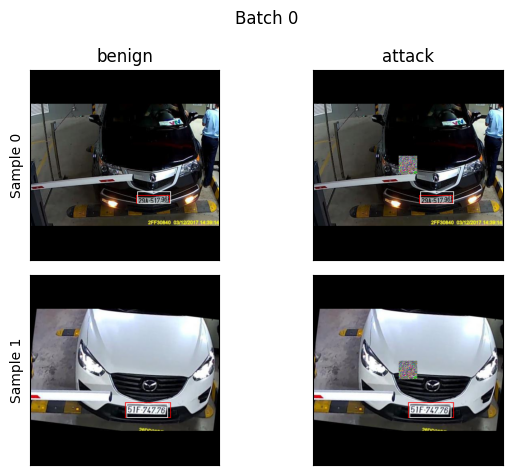

In [ ]:
display_object_detection_results(
    run_id=engine.run_id,
    batch_idx=0,
    batch_size=batch_size,
    chains=["benign", "attack"],
)